### Python Script to Compute Mann Kendall trends written by Herbert. O. Misiani and Modified by Samuel Ekwacu

### Computing persistent hot spell events trends over East Africa

In [88]:
## libraries to install for first time 
#conda install -c conda-forge regionmask
# conda install -c conda-forge geopandas
#conda install -c conda-forge descartes
#conda install -c conda-forge cartopy
#conda install -c conda-forge pymannkendall
#conda install -c conda-forge xeofs
#conda install -c conda-forge r-correlation
#conda install -c conda-forge pytest-regressions

In [39]:
import pymannkendall as mk
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from descartes import PolygonPatch
import matplotlib.path as mplPath
from shapely.geometry.polygon import Polygon
import geopandas as gpd
import shapefile as shp
import regionmask
import cartopy as cr # for geographic mapping
import cartopy.crs as ccrs # for map projections
import cartopy.feature as cfeature # to add coastlines, land and ocean
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [40]:
dh = xr.open_dataset('C:/Diabatic_data/dhr_monthly/fcst_phy3m125.241_lrghr_950hpa_1961-2021_monthly.nc')
#dh               
dh.var

<bound method ImplementsDatasetReduce._reduce_method.<locals>.wrapped_func of <xarray.Dataset>
Dimensions:                (g0_lon_2: 77, g0_lat_1: 65, time: 726)
Coordinates:
  * g0_lon_2               (g0_lon_2) float32 330.0 331.2 332.5 ... 63.75 65.0
  * g0_lat_1               (g0_lat_1) float32 40.0 38.75 37.5 ... -38.75 -40.0
  * time                   (time) datetime64[ns] 1961-01-31T18:00:00 ... 2021...
Data variables:
    LRGHR_GDS0_ISBL_ave6h  (time, g0_lat_1, g0_lon_2) float32 ...
    initial_time0_encoded  (time) float64 ...
Attributes:
    CDI:            Climate Data Interface version 1.5.3 (http://code.zmaw.de...
    Conventions:    None
    history:        Sun Apr 23 14:44:48 2023: cdo mergetime fcst_phy3m125.241...
    creation_date:  Sat Apr 22 21:13:16 MDT 2023
    NCL_Version:    6.6.2
    system:         Linux casper34 3.10.0-1127.18.2.el7.x86_64 #1 SMP Sun Jul...
    grib_source:    fcst_phy3m125.241_lrghr.1961010100_1961013118.ekwacu63201...
    title:          NC

In [41]:
#dh = dh.sel(time=slice("1961-01-31 18:00:00", "1990-12-31 18:00:00"))

In [42]:
dh.coords['g0_lon_2']=(dh.coords['g0_lon_2']+180)%360-180
dh=dh.sortby(dh.g0_lon_2) 

In [43]:
###For Annual Trends Only
Data =dh['LRGHR_GDS0_ISBL_ave6h'].groupby('time.year').mean('time')    ## Group data into yearly means for annual trends
#Data

In [44]:
#dat_samp = Data.sel(lon=slice(27.5, 42.5), lat=slice(-12, 5))  ## Slice to EA
dat_samp = Data.sel(g0_lon_2=slice(-20, 55), g0_lat_1=slice(40,-35))  ## Slice to Africa
slope_val = np.zeros((len(dat_samp.g0_lat_1.values),len(dat_samp.g0_lon_2.values)))
p_value = np.zeros((len(dat_samp.g0_lat_1.values),len(dat_samp.g0_lon_2.values)))
#output = []
for i in np.arange(len(dat_samp.g0_lat_1.values)):
    for j in np.arange(len(dat_samp.g0_lon_2.values)):
        
        try:
            slope_val[i,j] = mk.original_test(dat_samp[:,i,j]).slope  ## trend,h,p,z,tau,s,var_s,slope,intercept = mk.original_test(x,0.05)
            p_value[i,j] = mk.original_test(dat_samp[:,i,j]).p
        except:
            slope_val[i,j] = np.nan
            p_value[i,j] = np.nan
            
        #output.append(slope_val)

In [45]:
## Define data as Xarray dataset and save as netcdf
output1=xr.DataArray(slope_val, dims=('g0_lat_1', 'g0_lon_2'), coords={'g0_lat_1':dat_samp.g0_lat_1, 'g0_lon_2':dat_samp.g0_lon_2}, attrs=dict(description="slope.", units="sst year-1"),)
data1 = output1.rename("trend")

output2=xr.DataArray(p_value, dims=('g0_lat_1', 'g0_lon_2'), coords={'g0_lat_1':dat_samp.g0_lat_1, 'g0_lon_2':dat_samp.g0_lon_2}, attrs=dict(description="significance",),)
data2 = output2.rename("p_val")
#data2
## Save Data as netcdf
#data1.to_netcdf('C:/Diabatic_data/Af_CNHR_1991-2021_Annual_trend.nc', mode='w')
#data2.to_netcdf('C:/Diabatic_data/Af_CNHR_1991-2021_Annual_pvalue.nc', mode='w')
#data1

In [46]:
## read the Shapefile of the Area of interest for use in masking over the required region
#sf = gpd.read_file('F://Folder_2022//Research//EA_Shp//East_Africa-Disolved.shp')  ## Used in Masking
#sf2 = shp.Reader('F://Folder_2022//Research//EA_Shp//EA.shp')       ## Used in plotting

sf = gpd.read_file('D://Folder_2023//Research//Africa_Research//shapefile//Africa_admin1.shp')  ## Used in Masking
sf2 = shp.Reader('D://Folder_2023//Research//Africa_Research//shapefile//Africa.shp')       ## Used in plotting

## Mask the trends and p_values
trend_mask = regionmask.mask_3D_geopandas(sf, data1.g0_lon_2, data1.g0_lat_1, lon_name='g0_lon_2', lat_name='g0_lat_1')
pval_mask = regionmask.mask_3D_geopandas(sf, data2.g0_lon_2, data2.g0_lat_1, lon_name='g0_lon_2', lat_name='g0_lat_1')

trnd = data1.where(trend_mask)         ## clip the data with the mask
pval = data2.where(pval_mask)
#trnd = data1       
#pval = data2
#trnd

C:\Users\Samuel-NUIST\AppData\Local\Temp\ipykernel_13880\3913519423.py:30: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(bottom=0.08, right=0.8, top=0.8)


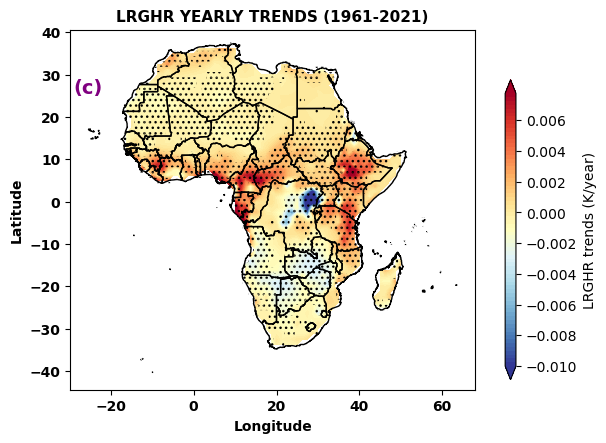

In [61]:
from matplotlib.colors import ListedColormap
none_map = ListedColormap(['none'])
fig, ax = plt.subplots(constrained_layout=True, figsize=(6, 5))

## Change this to the threshold you need.
#cond = (pval >= -0.05) & (pval <= 0.05)
cond = (pval <= 0.05)

## Mask out the areas that do not satisfy the conditions
sig_reg = pval.where(cond)

## Plotting the figure
for poly in sf2.shapes():
    poly_geo=poly.__geo_interface__
    ax.add_patch(PolygonPatch(poly_geo, fc='None', ec='black', alpha=1, fill='False', zorder=2))
    
cs = plt.contourf(dat_samp.g0_lon_2, dat_samp.g0_lat_1, trnd.values[:,:,0],  
      levels=np.arange(-0.01, 0.008, 0.00025),cmap=plt.cm.RdYlBu_r, extend='both') #RdBu #YlOrRd # RdYlBu #levels=np.arange(-3, 5, 1)
#levels=np.arange(-0.045, 0.06, 0.015),
hatch = ax.pcolor(dat_samp.g0_lon_2, dat_samp.g0_lat_1, sig_reg.data[:,:,0], cmap=none_map, 
                hatch='...', edgecolor='black', lw=0, zorder=4)
## title attributes
plt.title('LRGHR YEARLY TRENDS (1961-2021)',fontsize=11, fontweight='bold')
plt.xticks(size = 10, fontweight='bold')
plt.yticks(size = 10, fontweight='bold')
##labling the axis
plt.ylabel('Latitude',fontsize=10, fontweight='bold')
plt.xlabel('Longitude',fontsize=10, fontweight='bold')
##ploting the legend
plt.subplots_adjust(bottom=0.08, right=0.8, top=0.8)
#####cax = plt.axes([0.85, 0.1, 0.018, 0.6])s
###plt.colorbar(cax=cax)
fig.colorbar(cs, ax=ax,cax = plt.axes([0.85, 0.1, 0.018, 0.6]), label='LRGHR trends (K/year)')
plt.text(-40, 30, '(c)',fontsize = 14, color ='black', fontweight='bold')
# save output
#plt.savefig('C:/Diabatic_data/dhr_monthly/LRGHR trends_1961-2021.png', dpi=300)
plt.show()

### God is Greate















